# EdX Dataset - Prelim Data Story

In this notebook, we look at the EdX dataset to see if we can find a correlation between various factors such as the registrants age/education background/course/region etc and the course completion rate.To answer this main question, we look at the relationship between different variables and certification rate  in the form of charts and plots

# Exploratary Data Analysis on EdX Data (2013-14)

In [2]:
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sb

# EdX Dataset 


The dataset contains data about particpants who enrolled in MITx and HarvardX courses on EdX platform (Academic Year 2013: Fall 2012, Spring 2013, and Summer 2013). The data includes  aggregate records of participants activities on EdX (which some information such as 'user name' de-identified). The dataset has been downloaded from 

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/26147&version=10.0



In [3]:
# PATH to data file
file='HMXPC13_DI_v2_5-14-14.csv'
path='/Users/suka/Downloads/dataverse_files'
filename=path+'/'+file

# Description of the DataSet  

* **course_id** unique identifier with information about institution , course name and semester
* **userid_DI:** identifies  user / course participant 
* **registered** registered for course, (=1 for all records ) 
* **viewed:**  indicates the user has viewed the course content 
* **explored** indicates user has  accessed at least half of the chapters in the courseware 
* **certified** indicates the user has completed the course with passing grade 
* **final_cc_cname_DI** indicates the country / region of the user
* **LoE** level of education of the user
* **YoB** user-provided, year of birth. 
* **gender** user-provided. Possible values: m (male), f (female) and o (other). 
* **grade** final grade of the user  i
* **start_time_DI**  date of course registration.
* **last_event_DI** date of last interaction with course,
* **nevents** number of interactions with the course,
* **ndays_act** number of unique days student interacted with course.
* **nplay_video** number of play video events within the course. Example: “52”. 
* **nchapters**  number of chapters  completed by the student 
* **inconsistent_flag** identifies records that are internally inconsistent. 



In [4]:
#  READ THE CSV to data frame 
full_df = pd.read_csv(filename,parse_dates=True)


# Cleanup
Before we go any further, we need to convert/clean the dataset . Here are the changes done
* drop the dataset which user specified information ( YoB,Education,Gender ) incomplete
* split the course_id to retrieve institution , course name and semester / year
* map the course-id/code to course title (eg 'CS50x':'Computer Science')
* rename the column headings appropriately
* fill NaN with 0 values
* Insert "Age" column
* Set the datatypes of the columns appropriately
* add categorical order for the education level 
* convert the grade(0 to 1) to %

In [6]:
# Extract relevant fields 
data = full_df[['course_id','userid_DI','final_cc_cname_DI','LoE_DI','YoB','gender','start_time_DI','grade','viewed','explored','nevents','ndays_act','nplay_video','nchapters','certified','registered','incomplete_flag']].copy()

# split the course id into multiple fields
a,b,c = data['course_id'].str.split('/').str
data.insert(1,'institution',a)
data.insert(2,'course',b)

# clean up the year which has the _spring,_fall suffixes 
a = c.str.split('_').str[0]
b = c.str.split('_').str[1]

data.insert(3,'year',a)
data.insert(4,'term',b)

data.drop('course_id',axis=1,inplace=True)

# Create the mapping of course-id to title 
#courselist = {'CB22x':'Greek Heros', 'CS50x':'Computer Science','ER22x':'Justice','PH207x':'Health Stat','PH278x':'Health Env','14.73x':'Poverty','2.01x':'Structures','3.091x':'SS Chemistry','6.002x':'Circuits','6.00x':'Computer Pgming','7.00x':'Biology','8.02x':'Electricity & Magnetism','8.MReV':'Mechanics'}
courselist = {'CB22x':'Greek Heros', 'CS50x':'Comp Sci','ER22x':'Justice','PH207x':'Health Stat','PH278x':'Health Env','14.73x':'Poverty','2.01x':'Structures','3.091x':'SS Chemistry','6.002x':'Circuits','6.00x':'Comp Pgming','7.00x':'Biology','8.02x':'Elec & Magnetism','8.MReV':'Mechanics'}
data['course'].replace(courselist, inplace=True)
data['course'].replace(courselist, inplace=True)

#rename columns 
data.rename(columns={'nchapters':'chapters viewed','ndays_act':'days active','nplay_video':'videos played','course_id': 'course', 'final_cc_cname_DI': 'country','LoE_DI':'education','userid_DI':'user',"start_time_DI":"start-time"}, inplace=True)

data['YoB'] = data.groupby('course')['YoB'].transform(lambda x: x.fillna(x.median()))
data['gender'] = data.groupby('course')['gender'].transform(lambda x: x.fillna(x.value_counts().index[0]))
data['education'] = data.groupby('course')['education'].transform(lambda x: x.fillna(x.value_counts().index[0]))


In [7]:

# change the datatypes of some of the columns
data['institution']= data.institution.astype('category')
data['course']= data.course.astype('category')

e_order = ["Less than Secondary","Secondary","Bachelor's","Master's","Doctorate"]
#e_type = pd.api.types.CategoricalDtype(categories=["Less than Secondary","Secondary","Bachelor's","Master's","Doctorate"], ordered=True)

data['grade'] = pd.to_numeric(data['grade'],errors='coerce')
data['grade'] = data['grade'].fillna(0).multiply(100)

data['education']= data.education.astype('category').cat.set_categories(e_order, ordered=True)

#Fill NaN data with zeros
data['chapters viewed'].fillna(0,inplace=True) # replace NaN with 0 
data['nevents'].fillna(0,inplace=True) # replace NaN with 0 
data['videos played'].fillna(0,inplace=True) # replace NaN with 0 
data['chapters viewed'].fillna(0,inplace=True) # replace NaN with 0 
data['days active'].fillna(0,inplace=True) # replace NaN with 0 
data['term'].fillna('Fall',inplace=True)

data['gender']= data.gender.astype('category')
data['year']= data.year.astype('int')
data['YoB']= data.YoB.astype('int')
data['nevents']= data.nevents.astype('int')

data['start-time'] = pd.to_datetime(data['start-time'])

# Add a column "age" using YoB (age calculated as on 2014)
data.insert(3,"age", [(x.year-x.YoB) for index, x in data.iterrows() ])

In [8]:
print("Extracted "+str(len(data))+" clean records from "+str(len(full_df))+" in the originsl dataset")
print("No of certifications  in full dataset - "+str(len(full_df[full_df.certified == 1])))
print("No of certifications  in cleaned dataset - "+str(len(data[data.certified == 1])))

Extracted 641138 clean records from 641138 in the originsl dataset
No of certifications  in full dataset - 17687
No of certifications  in cleaned dataset - 17687


In [9]:
# pick a random subset of  data points for plotting
rdm = np.random.choice(len(data), replace=False, size=20000)
data_trim = data.iloc[rdm]

# Is the course completion rate similar across various courses ?

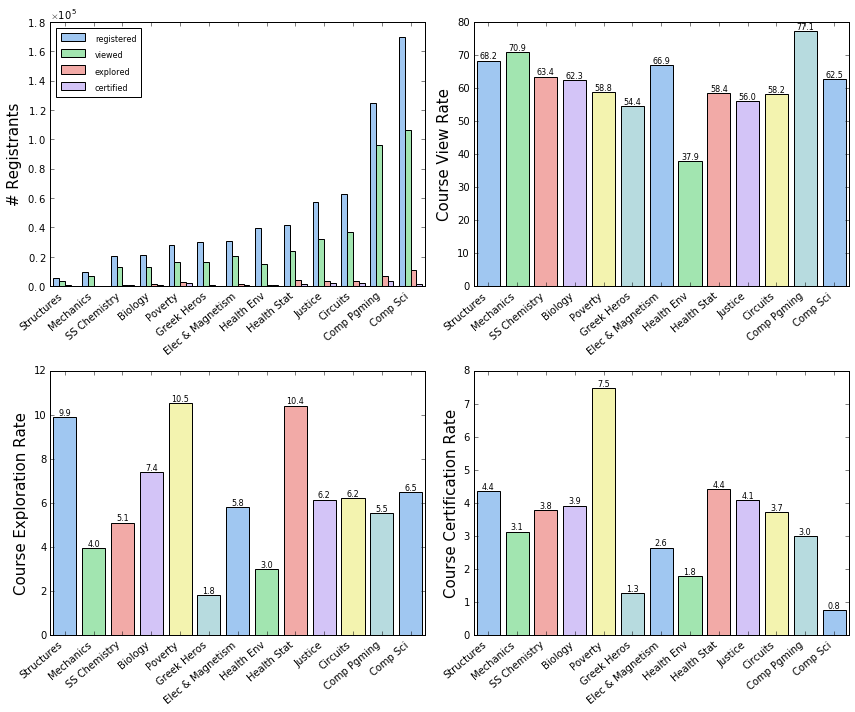

In [12]:
aggregations = { 'certified':'sum','registered':'sum','viewed':'sum','explored':'sum'}

%matplotlib inline

cdata = data.groupby(['course'],as_index=False).agg(aggregations)
olist = cdata.sort_values("registered").course #ordered list 
tidydata = (
    cdata.set_index('course')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)

tidydata = tidydata.sort_values("Value")
tidydata['Variable']= tidydata.Variable.astype('category',ordered=True,categories=["registered","viewed","explored","certified"])

fig, axs = plt.subplots(2,2,figsize=(12,10))
#deep, muted, pastel, bright, dark, and colorblind

# Sub plot 1
ax=sb.barplot(x='course', y='Value', hue='Variable',order=olist,data=tidydata,palette="pastel",ax=axs[0,0])
ax.set(ylim=(0,None))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.tick_params(labelsize=10)
ax.set_ylabel('# Registrants',fontsize=15)
ax.set_xlabel('',fontsize=10)
ax.legend(ncol=1, loc='upper left');

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.major.formatter._useMathText = True
plt.setp(ax.get_legend().get_texts(), fontsize='8')
plt.setp(ax.get_legend().get_title(), fontsize='8')


cdata['rate'] = [ (100 * x.certified / x.registered) for index, x in cdata.iterrows() ]
cdata['exprate'] = [ (100 * x.explored / x.registered) for index, x in cdata.iterrows() ]
cdata['viewrate'] = [ (100 * x.viewed / x.registered) for index, x in cdata.iterrows() ]

#plt.ylim(0,10)
ax=sb.barplot(x="course", y="rate", order=olist,data=cdata,palette="pastel",ax=axs[1,1]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");
ax.tick_params(labelsize=10);
ax.set_ylabel('Course Certification Rate',fontsize=15);
ax.set_xlabel('',fontsize=10);

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.1f' % p.get_height(), 
            fontsize=8,  ha='center', va='bottom');


ax=sb.barplot(x="course", y="exprate", order=olist,data=cdata,palette="pastel",ax=axs[1,0]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.tick_params(labelsize=10)
ax.set_ylabel('Course Exploration Rate',fontsize=15)
ax.set_xlabel('',fontsize=10)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.1f' % p.get_height(), 
            fontsize=8,  ha='center', va='bottom');
ax=sb.barplot(x="course", y="viewrate", order=olist,data=cdata,palette="pastel",ax=axs[0,1]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.tick_params(labelsize=10)
ax.set_ylabel('Course View Rate',fontsize=15)
ax.set_xlabel('',fontsize=10)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.1f' % p.get_height(), 
            fontsize=8,  ha='center', va='bottom');
fig.tight_layout()
plt.show()


## Observations
We find the course registration rates significantly higher for some of the STEM courses like computer science/programming/circuits and this makes up nearly 40% of the dataset . The content view rate , exploration rate (view of more than 50% course content) and the certification rates are similar
Observations
* For all courses, % of registrants who open the content varies from 38% to 78%
* The number of registrants who complete atleast 50% course material varies from 2% to 10%
* Course completion rate varies from 0.8% to 7%
* Enrollment in Computer Courses make up more than 40% of the dataset
* CS course has the least certification rate


# Is the progress and grades dependent on the  course  ?

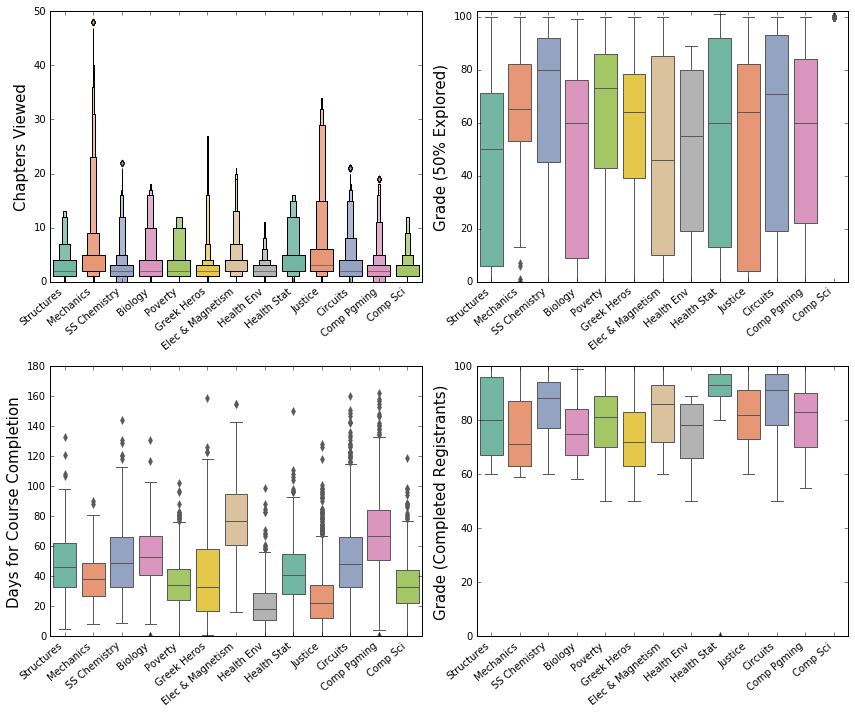

In [13]:
 
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(12,10))

ax = sb.lvplot(x="course", y="chapters viewed",data=data[data.viewed==1],order=olist,palette="Set2",ax=axs[0,0]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");
ax.set(ylim=(0,50))
ax.tick_params(labelsize=10)
ax.set_ylabel('Chapters Viewed',fontsize=15)
ax.set_xlabel('',fontsize=20)

#ax = sb.boxplot(x="course", y="videos played", data=data,order=olist,palette="Set2", dodge=True,ax=axs[0,1])
#ax.set(ylim=(0,2000))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#ax.set_ylabel('Videos Played',fontsize=15)
#ax.tick_params(labelsize=10)
#ax.set_xlabel('',fontsize=20)


ax = sb.boxplot(x="course", y="grade", data=data[data.explored==1],order=olist,palette="Set2", dodge=True,ax=axs[0,1])
ax.set(ylim=(0,102))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel('Grade (50% Explored)',fontsize=15)
ax.tick_params(labelsize=10)
ax.set_xlabel('',fontsize=20)

ax = sb.boxplot(x="course", y="days active", data=data[data.certified==1],order=olist,palette="Set2", dodge=True,ax=axs[1,0])
ax.set(ylim=(0,None))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel('Days for Course Completion',fontsize=15)
#ax.axes.set_title('Time for course completion',fontsize=15)
ax.tick_params(labelsize=10)
ax.set_xlabel('',fontsize=20)

ax = sb.boxplot(x="course", y="grade", data=data[data.certified==1],order=olist,palette="Set2", dodge=True,ax=axs[1,1])
ax.set(ylim=(0,100))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel('Grade (Completed Registrants)',fontsize=15)
#ax.axes.set_title('Grade (students who completed course)',fontsize=30)
ax.tick_params(labelsize=10)
ax.set_xlabel('',fontsize=20)
plt.tight_layout()




# Observations
* We find the median value for course content/chapters viewed to be less than 5.
* The average days for course completion ranges between between 30 and 60 with a few outliers and few inconsistent data (course completions in < 4-5days). 
* CS course which has the least certification rate, has 100% grade for all course completions

# Is the certification dependent on the user/# courses taken by the user  ?

In [18]:
vdata = data[data.viewed==1]
aggregations = { 'registered':'sum'}

c_user  = vdata.groupby(['user'],as_index=False).agg(aggregations)
x = c_user.groupby(['registered'],as_index=False).count()
x.columns = ["#courses taken","registrants"]
y = x.iloc[:, ::-1]

cm = sb.light_palette("green", as_cmap=True)
y.style.background_gradient(cmap=cm)

,registrants,#courses taken
0,272491,1
1,40845,2
2,9276,3
3,2670,4
4,814,5
5,297,6
6,104,7
7,38,8
8,23,9
9,13,10


# Number of Courses taken by users who completed a course 

In [19]:
cvdata = data[data.certified==1]
aggregations = { 'registered':'sum'}

c_user  = cvdata.groupby(['user'],as_index=False).agg(aggregations)
x = c_user.groupby(['registered'],as_index=False).count()
x.columns = ["#courses taken","registrants"]
y = x.iloc[:, ::-1]

cm = sb.light_palette("red", as_cmap=True)
y.style.background_gradient(cmap=cm)

,registrants,#courses taken
0,14977,1
1,1065,2
2,156,3
3,18,4
4,8,5


# Observations
* From the courses taken by users (in 1 year window) , we find a number of users with more than 1 course registration 
* And a quite a few who registrants who have signed up for all(13+) courses . 
* We need to see if some of these records are invalid/administrative 
* Among those who completed courses there are 1000+ users who have completed 2 or more courses . With 8 users who have completed 5 courses 

# Age Distribution of participants 

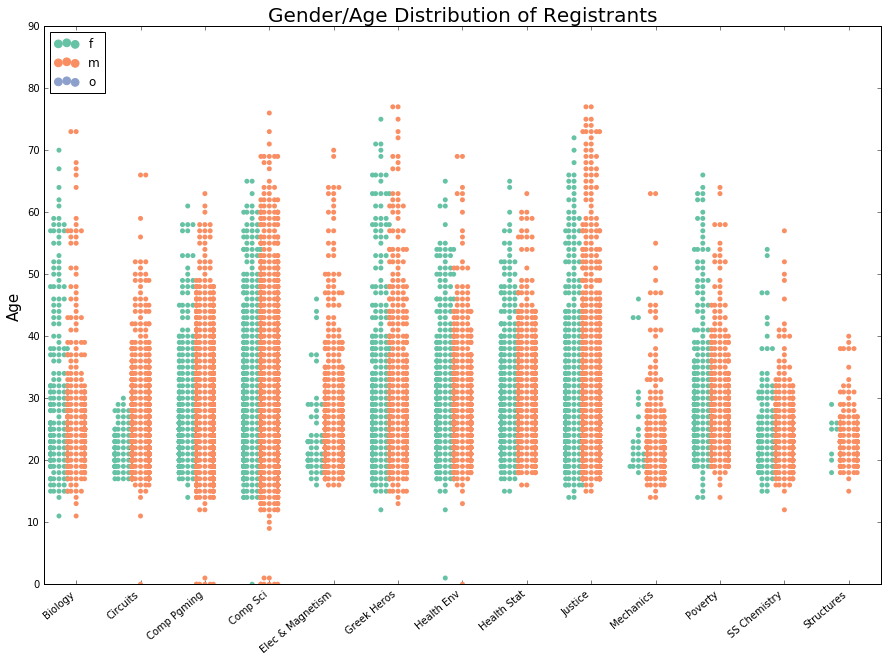

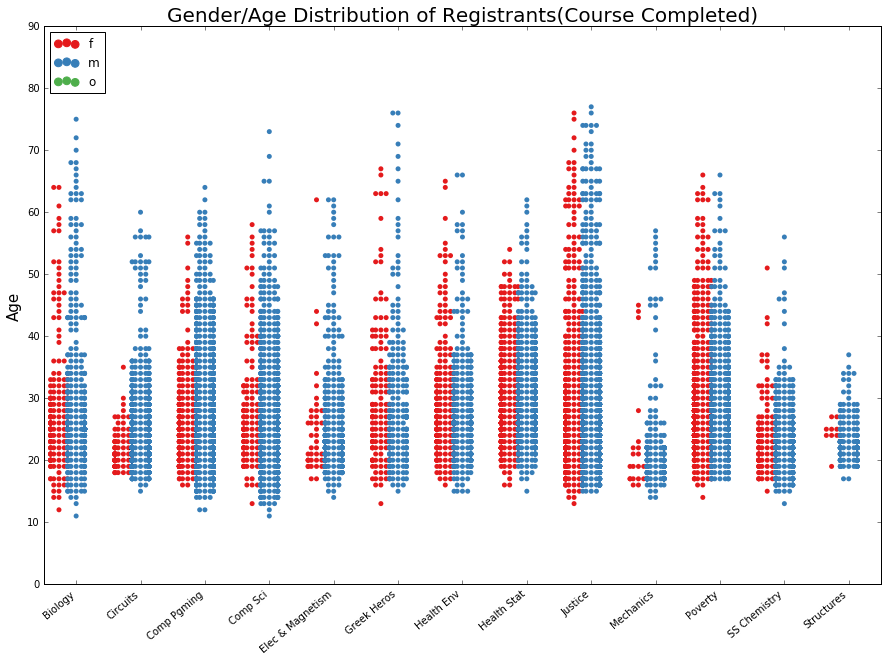

In [16]:
%matplotlib inline
plt.figure(figsize=(15,10))
ax = sb.swarmplot(x="course", y="age", hue="gender",data=data_trim,palette="Set2", dodge=True)
ax.set(ylim=(0,90))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.axes.set_title('Gender/Age Distribution of Registrants',fontsize=20)
ax.tick_params(labelsize=10)
ax.set_ylabel('Age',fontsize=15)
ax.set_xlabel('',fontsize=15)
ax.legend(ncol=1, loc='upper left');

plt.figure(figsize=(15,10))
ax = sb.swarmplot(x="course", y="age", hue="gender",data=data[data.certified==1],palette="Set1", dodge=True)
ax.set(ylim=(0,90))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.axes.set_title('Gender/Age Distribution of Registrants(Course Completed)',fontsize=20)
ax.tick_params(labelsize=10)
ax.set_ylabel('Age',fontsize=15)
ax.set_xlabel('',fontsize=15)
ax.legend(ncol=1, loc='upper left');

In [51]:
cvdata = data[data.certified==1][['course','gender','certified']]

x  = cvdata.groupby(['course','gender'],as_index=False).count()
x['certified'].fillna(0,inplace=True)
cm = sb.light_palette("orange", as_cmap=True)
x.style.background_gradient(cmap=cm)

,course,gender,certified
0,Biology,f,226
1,Biology,m,597
2,Biology,o,0
3,Circuits,f,186
4,Circuits,m,2157
5,Circuits,o,0
6,Comp Pgming,f,365
7,Comp Pgming,m,3365
8,Comp Pgming,o,0
9,Comp Sci,f,162


# Observations
* the age range for users varies from 10+ to 80 
* there are a few users wih age 0 registered for the course (invalid data ?)
* gender ratio of the users for STEM courses is skewed while it is more balanced for the Humanities courses


# As the computer courses make up more than 40% of the dataset , we look at this group in detail 

In [70]:
# extract the computer course participant details and then get a random sample of 10000 data points for visualization 
csdata = data[data['course'].str.contains("Comp")]
rdm = np.random.choice(len(csdata), replace=False, size=10000)
csdata_trim = csdata.iloc[rdm]
x= len(csdata)
p = x / len(data) * 100
print("Computer courses make up {0:.2f} of dataset".format(p))
y = len(csdata[csdata.certified==1])
print("No of Computer course registrants =  {}".format(x))
print("No of Computer course certifications =  {}".format(y))

Computer courses make up 45.87 of dataset
No of Computer course registrants =  294067
No of Computer course certifications =  5017


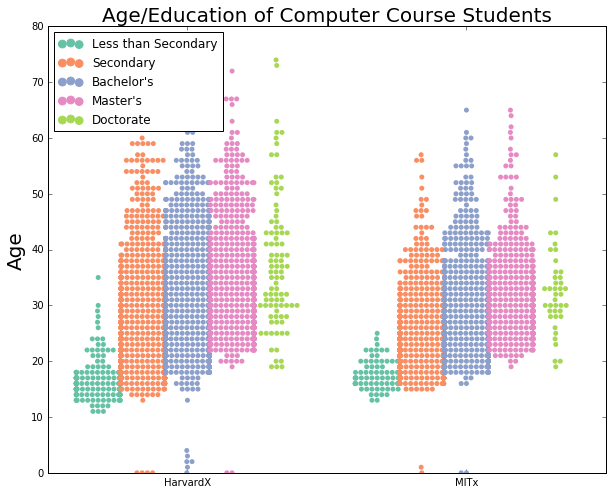

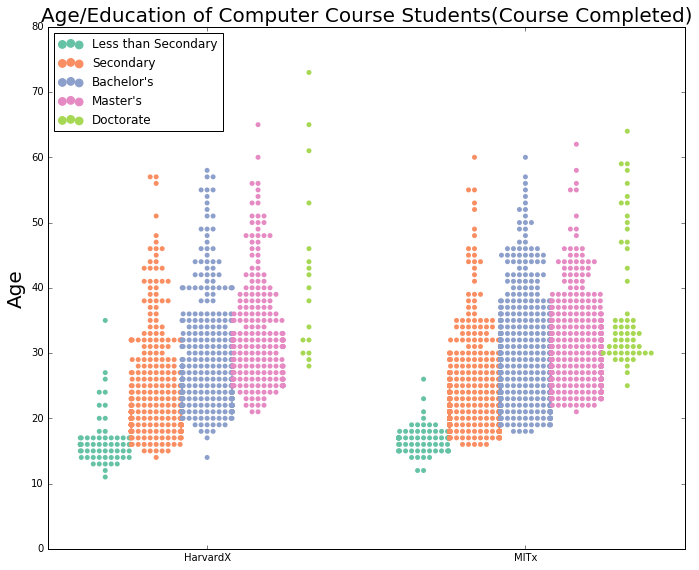

In [144]:
# Age distribution for  CS students
%matplotlib inline
plt.figure(figsize=(10,8))
ax = sb.swarmplot(x="institution", y="age", hue="education", data=csdata_trim,palette="Set2", dodge=True)
ax.set(ylim=(0,None))
ax.axes.set_title('Age/Education of Computer Course Students',fontsize=20)
ax.tick_params(labelsize=10)
ax.set_ylabel('Age',fontsize=20)
ax.set_xlabel('',fontsize=20)
ax.legend(ncol=1, loc='upper left');


plt.figure(figsize=(10,8))
ax = sb.swarmplot(x="institution", y="age", hue="education", data=csdata[csdata.certified==1],palette="Set2", dodge=True)
ax.set(ylim=(0,None))
ax.axes.set_title('Age/Education of Computer Course Students(Course Completed)',fontsize=20)
ax.tick_params(labelsize=10)
ax.set_ylabel('Age',fontsize=20)
ax.set_xlabel('',fontsize=20)
ax.legend(ncol=1, loc='upper left');


# Observations 
* Computer courses have the highest enrollment rate and lowest certification rate 
* there are a few users wih age 0-5 registered for the course (invalid data ?)
* Users with secondary , bachelors and masters degree have a higher enrollment / certification rate

# Breakup of course completion rates @ education level 

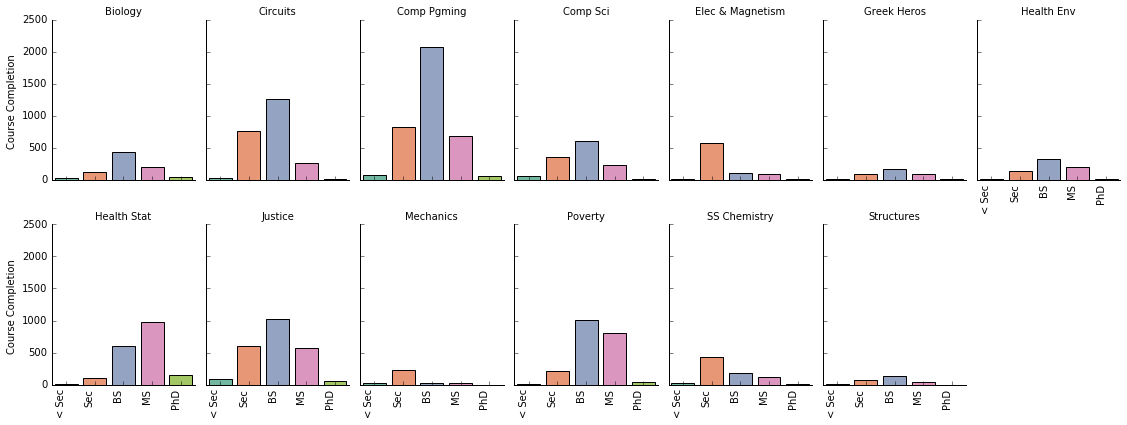

In [71]:
aggregations = { 'certified':'sum','registered':'sum','viewed':'sum'}

%matplotlib inline

course_data = data.groupby(['course','institution','education'],as_index=False).agg(aggregations)
course_data['rate'] = [ int(100 * x.certified / x.registered) for index, x in course_data.iterrows() ]

edu = ["< Sec","Sec","BS","MS","PhD"]

plt.figure(figsize=(18,12))
g=sb.factorplot(col="course", y="certified",x='education',palette="Set2",data=course_data, kind='bar',col_wrap=7,size=3, aspect=.75);
(g.set_axis_labels("", "Course Completion ")
   .set_xticklabels(edu,rotation=90, ha="right")
   .set_titles("{col_name}"))

plt.tight_layout()


# Observations 
* Users with bachelors , masters degree (and secondary level for few courses) have higher certification rate 

# Countrywise Breakup of course registration / completion rates 

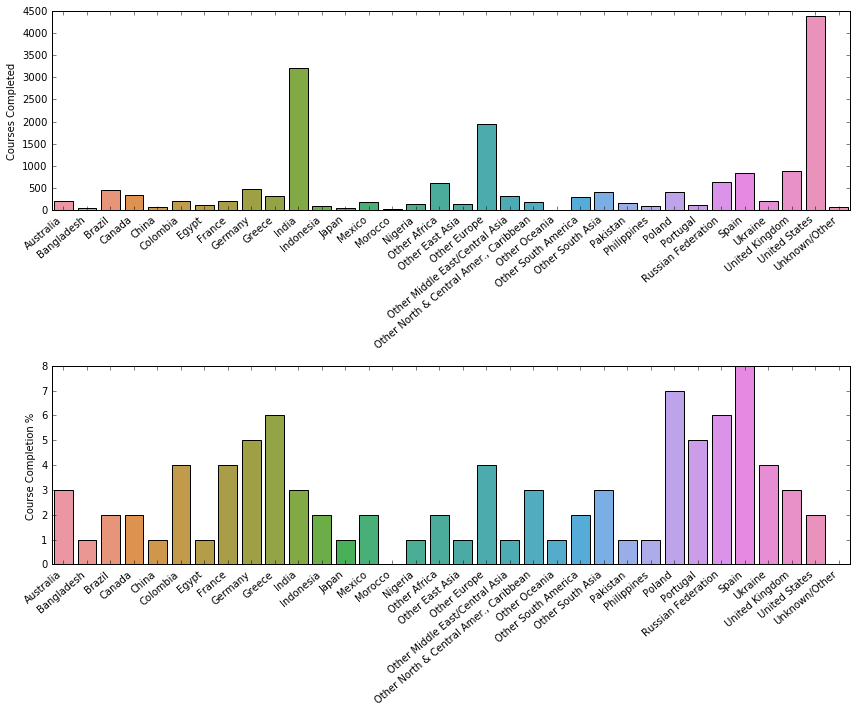

In [89]:
%matplotlib inline
fig, axs = plt.subplots(2,1,figsize=(12,10))

# Extract the country specific data and calculate the % %certification rate
country_data = data[['country','certified','registered']].groupby('country',as_index=False).sum()
country_data['rate'] = [ int(100 * x.certified / x.registered) for index, x in country_data.iterrows() ]

ax=sb.barplot(x="country", y="certified", data=country_data,ax=axs[0]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");
ax.set(xlabel='Country', ylabel='Courses Completed');
ax.set_xlabel('',fontsize=20);

ax=sb.barplot(x="country", y="rate", data=country_data,ax=axs[1]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");
ax.set(xlabel='Country', ylabel='Course Completion %');
ax.set_xlabel('',fontsize=20);

fig.tight_layout();


# Observations 
* Number of course completions higher/concentrated in a few regions (India,Europe,US) 

# Courses Registered/Completed in various age groups 

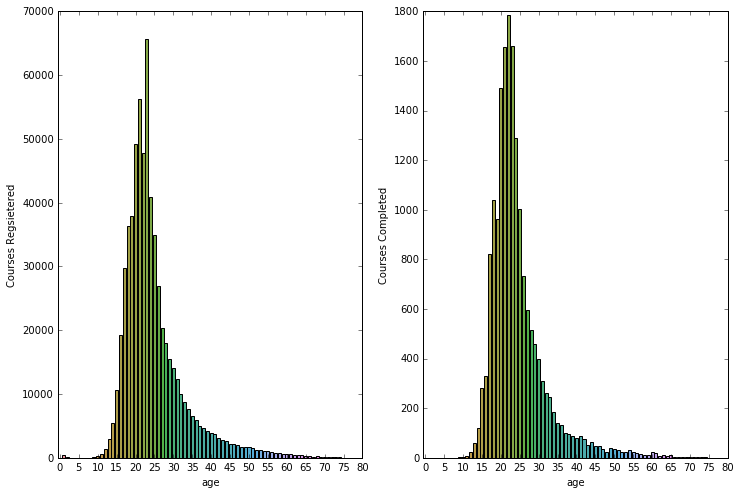

In [82]:
#plt.figure(figsize=(8,6))
fig, axs = plt.subplots(1,2,figsize=(12,8))
age_data = data[['age','certified','registered']].groupby('age',as_index=False).sum()
xt=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]

ax=sb.barplot(x="age", y="registered", data=age_data,ax=axs[0]);
ax.set_xticklabels(xt);
ax.set(xlabel='age', ylabel='Courses Regsietered',xticks=xt);


#plt.figure(figsize=(12,8))
ax=sb.barplot(x="age", y="certified", data=age_data,ax=axs[1]);
ax.set_xticklabels(xt);
ax.set(xlabel='age', ylabel='Courses Completed',xticks=xt);


# Observations 
* Number of course registrations and completions are higher in the age group 16-40 

# Correlation between various factors and completion rates 

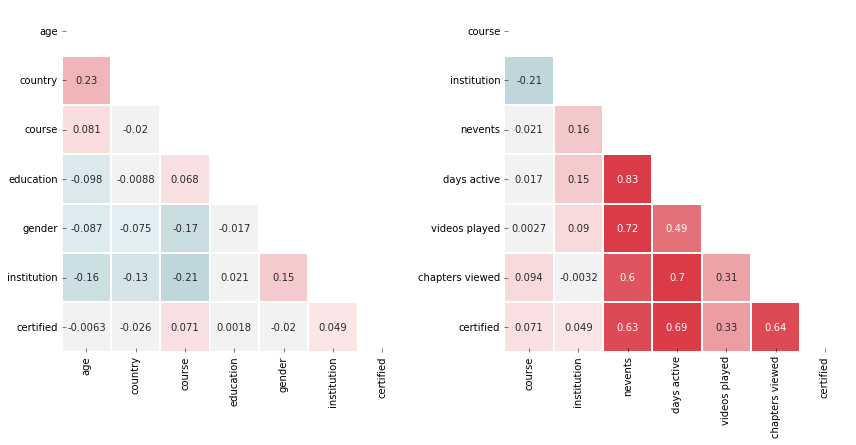

In [106]:
modeldata = data.copy()
encoder = LabelEncoder()
icode = encoder.fit_transform(data['institution'])
ccode = encoder.fit_transform(data['country'])
cscode = encoder.fit_transform(data['course'])
educode = encoder.fit_transform(data['education'])
gendercode=encoder.fit_transform(data['gender'])
usercode=encoder.fit_transform(data['user'])

# Eliminate the categorical data and use the encoded information 
modeldata.drop(['institution','term','start-time','course','country','explored','education','YoB','year','gender','registered','user','incomplete_flag'],axis=1,inplace=True)

#modeldata.insert(0,"user",usercode)
modeldata.insert(1,"country",ccode)
modeldata.insert(2,"course",cscode)
modeldata.insert(3,"education",educode)
modeldata.insert(4,"gender",gendercode)
modeldata.insert(5,"institution",icode)

fig, axs = plt.subplots(1,2,figsize=(12,10))

sdata = modeldata[modeldata.viewed==1].copy()
sdata.drop(['viewed','grade','nevents','days active','videos played','chapters viewed'],axis=1,inplace=True)

corr = sdata.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.7,center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5},ax=axs[0],annot=True,cbar=False);

sdata = modeldata[modeldata.viewed==1].copy()
sdata.drop(['viewed','grade','country','education','gender','age'],axis=1,inplace=True)

corr = sdata.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap,vmax=.7, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5},ax=axs[1],annot=True,cbar=False);
fig.tight_layout();

# Observations 
* There is very little correlation between the user info (age/gender/eductaion) and the course completion.
* However by taking in some of the administrative variables such as the number of interactions etc , we see a improved correlation with the certification rate 